# Работа с Dog Segmentation Dataset

Задача: семантическая сегментация собак ^_^

Датасет: [Dog Segmentation Dataset](https://www.kaggle.com/datasets/santhoshkumarv/dog-segmentation-dataset)

In [1]:
# Подключение Гугл диска
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### EDA
В датасете есть картинки животных и соответствующие маски.

Всего изображений - 180. Изображений мало. Этот датасет используется исключительно в целях тестирования работы с кастомным датасетом.

#### <u>*В дальнейшем будет использоваться датасет OxfordIIITPet</u>*.

Изображения имеют разный размер, поэтому данные необходимо предварительно отмасштабировать.

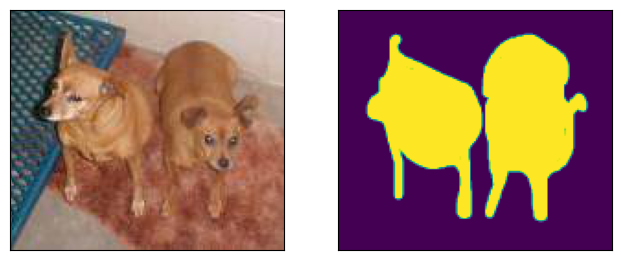

In [ ]:
from matplotlib import pyplot as plt

names = ['Image', 'Mask']

plt.figure(figsize=(12, 12))

plt.subplot(131)
img = plt.imread('/content/drive/MyDrive/SpaceDogs/data/test/images/dog.8940.jpg')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
msk = plt.imread('/content/drive/MyDrive/SpaceDogs/data/test/labels/annotated_dog.8940.jpg')
plt.imshow(msk)
plt.xticks([])
plt.yticks([])
plt.show()

### Подготовка данных

Все изображения нужно перевести в тензоры.

Тензоры нужно отмасштабировать и нормализовать. Для этого нужно получить среднее и стандартное отклонение у значений пикселей в нашем датасете.

Если в ходе обучения выясниться, что данных мало, можно добавить аугментаций к исходным изображениям.

In [ ]:

from pathlib import Path


# Объявим пути к файлам
train_x_path = Path('/', 'content', 'drive', 'MyDrive', 'SpaceDogs', 'data', 'train', 'images')
train_y_path = Path('/', 'content', 'drive', 'MyDrive', 'SpaceDogs', 'data', 'train', 'labels')

test_x_path = Path('/', 'content', 'drive', 'MyDrive', 'SpaceDogs', 'data', 'test', 'images')
test_y_path = Path('/', 'content', 'drive', 'MyDrive', 'SpaceDogs', 'data', 'test', 'labels')

In [ ]:
'''
Инициализируем класс датасета
'''

from torch.utils.data import Dataset
from PIL import Image
import os

class DogsDataset(Dataset):
    def __init__(self, path_x: str | Path = 'data',
                 path_y: str | Path = 'data', train_transform=None, test_transform=None):
        self.path_x = path_x
        self.path_y = path_y
        self.x_samples = [el for el in os.listdir(self.path_x) if el.endswith('.jpg')]
        self.y_samples = [el for el in os.listdir(self.path_y) if el.endswith('.jpg')]
        self.train_transform = train_transform
        self.test_transform = test_transform

    def __getitem__(self, idx):
        x_img_path = Path(self.path_x, self.x_samples[idx])
        y_img_path = Path(self.path_y, self.y_samples[idx])

        x_img = Image.open(x_img_path)
        y_img = Image.open(y_img_path)

        if self.train_transform is not None:
            x_img = self.train_transform(x_img)
        if self.test_transform is not None:
            y_img = self.test_transform(y_img)

        return x_img, y_img

    def __len__(self):
        return len(self.x_samples)


In [ ]:
'''
Функция для сохдания аугментаций (в данном случае, происходит только масштабирование)
'''

import torchvision.transforms as T

def get_augmentations(train: bool = True) -> T.Compose:
    if train:
        train_transforms = T.Compose(
          [
            T.Resize((512, 512)),
            T.ToTensor(),
          ]
        )
        return train_transforms

    test_transforms = T.Compose(
      [
          T.Resize((512, 512)),
          T.ToTensor(),
      ]
    )
    return test_transforms

In [ ]:
'''
Инициализируем датасеты
'''

# Импорт необходимых библиотек
import tensorflow as tf
import torch
import torchvision
from torch.utils.data import DataLoader

In [ ]:
train_dataset = DogsDataset(path_x=train_x_path, path_y=train_y_path,
                            train_transform=get_augmentations(train=True),
                            test_transform=get_augmentations(train=False))

test_dataset = DogsDataset(path_x=test_x_path, path_y=test_y_path,
                            train_transform=get_augmentations(train=True),
                            test_transform=get_augmentations(train=False))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=4, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=4, num_workers=2)

### Архитектра модели

Интересная статья: [SAM](https://habr.com/ru/articles/727482/)


В качестве архитектуры можно протестирвоать U-Net

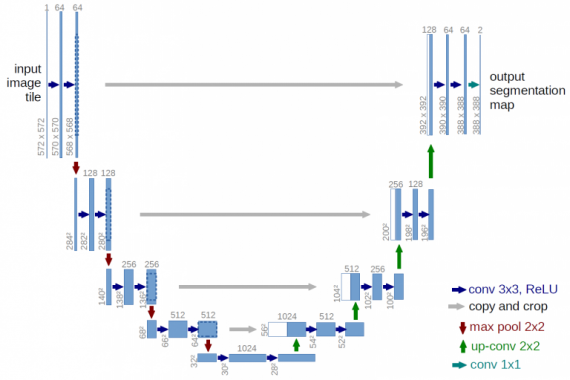

In [ ]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        # 3 * 572 * 572
        self.encoder1 = UNet._block(in_channels, features, name="enc1")         # 32  * 572 * 572
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)                      # 32  * 286 * 286
        self.encoder2 = UNet._block(features, features * 2, name="enc2")        # 64  * 286 * 286
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)                      # 64  * 143 * 143
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")    # 128 * 143 * 143
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)                      # 128 * 71  * 71
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")    # 256 * 71  * 71
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)                      # 512 * 35  * 35

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck") # 1024 * 35 * 35

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

        self.final = nn.Softmax(dim=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        x = self.conv(dec1)
        return x

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                in_channels=features,
                out_channels=features,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(num_features=features),
            nn.ReLU(inplace=True),
        )

### Функции для обучения модели

In [ ]:
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch


def train(
    model: nn.Module,
    data_loader: DataLoader,
    optimizer: Optimizer,
    loss_fn,
    device: torch.device,
):
    model = model.to(device)
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(data_loader)
    accuracy = correct / total

    return train_loss, accuracy


@torch.inference_mode()
def evaluate(
    model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
):
    model = model.to(device)
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(data_loader)
    accuracy = correct / total

    return total_loss, accuracy

In [ ]:
import torch
from torch import nn, optim
from torch.optim import Optimizer
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn
) -> tuple[float, float]:
    model.to(device)
    model.train()
    train_loss = 0

    for x, y in tqdm(data_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output[0], y[0])

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)

    return train_loss


@torch.inference_mode()
def evaluate(model, data_loader, loss_fn, device) -> tuple[float, float]:
    model.to(device)
    model.eval()

    total_loss = 0

    for x, y in tqdm(data_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        output = model(x)

        loss = loss_fn(output[0], y[0])

        total_loss += loss.item()

    total_loss /= len(data_loader)

    return total_loss

### Объявление объектов для обучения

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = UNet()
# model.load_state_dict(torch.load(r'/content/drive/MyDrive/SpaceDogs/models/weights_models_7.pth'))

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = StepLR(optimizer, step_size=10)

loss_fn = nn.CrossEntropyLoss()

### Обучение модели

In [ ]:
epoch = 200
best_score = 1000000
for i in range(1, epoch + 1):
    print(f'\nStart epoch {i}')
    train_val = train(model, train_dataloader, optimizer, loss_fn, device)
    test_val = evaluate(model, test_dataloader, loss_fn, device)
    print(f'\nTrain val: {train_val[1]}\nTest val: {test_val[1]}')
    if best_score > test_val[1]:
        best_score = test_val[1]
        torch.save(model.state_dict(), f'/content/drive/MyDrive/SpaceDogs/models/weights_models_{i}.pth')



Start epoch 1


Evaluation: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]



Train val: 0.6020488739013672
Test val: 0.6078405380249023

Start epoch 2


Evaluation: 100%|██████████| 5/5 [00:00<00:00,  5.39it/s]



Train val: 0.6020488739013672
Test val: 0.6078405380249023

Start epoch 3


Evaluation: 100%|██████████| 5/5 [00:00<00:00,  5.99it/s]



Train val: 0.6020488739013672
Test val: 0.6078405380249023

Start epoch 4


Train:  32%|███▎      | 13/40 [00:04<00:09,  2.81it/s]


KeyboardInterrupt: ignored

### Проверка результатов

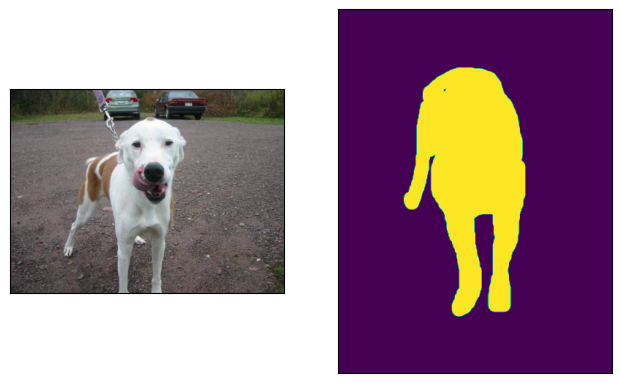

In [ ]:
from matplotlib import pyplot as plt

names = ['Image', 'Mask']

plt.figure(figsize=(12, 12))

plt.subplot(131)
img = plt.imread('/content/drive/MyDrive/SpaceDogs/data/test/images/dog.8965.jpg')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.subplot(132)
msk = plt.imread('/content/drive/MyDrive/SpaceDogs/data/test/labels/annotated_dog.8966.jpg')
plt.imshow(msk)
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
import torchvision.transforms as T

def get_img(img: torch.tensor):
    transforms = T.Compose([T.ToPILImage()])
    return transforms(img)

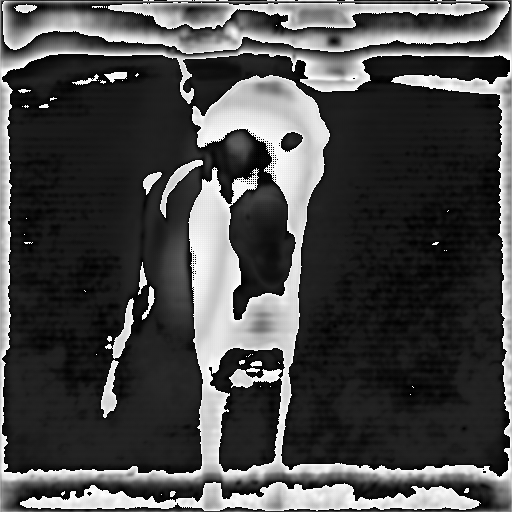

In [ ]:
x_img = Image.open('/content/drive/MyDrive/SpaceDogs/data/test/images/dog.8965.jpg')
x_img = get_augmentations(train=True)(x_img)
x_img = torch.stack([x_img]).to(device)
# x_img.shape
model.to(device)
x_img = (model(x_img))[0]

# (model(x_img) > 0.5)[0]


PIL_img = T.ToPILImage()(x_img[0])
PIL_img.show()

### Вывод
Изображений в датасете крайне мало. Однако, этот фрагмент кода служит лишь демонстрацие того, что можно настроить работу со своим датасетом.

# Работа с OxfordIIITPet

### Подготовка данных

In [2]:
import torchvision
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms as T

transform = T.Compose(
        [
            T.Resize((512, 512)),
            T.ToTensor(),
        ]
    )

target_transform = T.Compose(
    [
        T.Resize((512, 512)),
        T.PILToTensor(),
        T.Lambda(lambda x: (x - 1).long())
    ]
)

train_dataset = OxfordIIITPet('/content/drive/MyDrive/SpaceDogs/oxfordData', transform=transform, download=True, target_transform=target_transform, target_types='segmentation')
valid_dataset = OxfordIIITPet('/content/drive/MyDrive/SpaceDogs/oxfordData', transform=transform, download=True, split='test', target_transform=target_transform, target_types='segmentation')

### Формируем архитектуру сети

In [3]:
#!g1.1
import torch.nn as nn


def conv_plus_conv(in_channels: int, out_channels: int):
    return nn.Sequential(
        nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
        nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=1,
            padding=1
        ),
        nn.BatchNorm2d(num_features=out_channels),
        nn.LeakyReLU(0.2),
    )


class UNET(nn.Module):
    def __init__(self):
        super().__init__()

        base_channels = 16

        self.down1 = conv_plus_conv(3, base_channels)
        self.down2 = conv_plus_conv(base_channels, base_channels * 2)
        self.down3 = conv_plus_conv(base_channels * 2, base_channels * 4)
        self.down4 = conv_plus_conv(base_channels * 4, base_channels * 8)
        self.down5 = conv_plus_conv(base_channels * 8, base_channels * 16)


        self.up1 = conv_plus_conv(base_channels * 2, base_channels)
        self.up2 = conv_plus_conv(base_channels * 4, base_channels)
        self.up3 = conv_plus_conv(base_channels * 8, base_channels * 2)
        self.up4 = conv_plus_conv(base_channels * 16, base_channels * 4)
        self.up5 = conv_plus_conv(base_channels * 32, base_channels * 8)


        self.bottleneck = conv_plus_conv(base_channels * 16, base_channels * 16)

        self.out = nn.Conv2d(in_channels=base_channels, out_channels=3, kernel_size=1)

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # x.shape = (N, N, 3)

        residual1 = self.down1(x)  # x.shape: (N, N, 3) -> (N, N, base_channels)
        x = self.downsample(residual1)  # x.shape: (N, N, base_channels) -> (N // 2, N // 2, base_channels)

        residual2 = self.down2(x)  # x.shape: (N // 2, N // 2, base_channels) -> (N // 2, N // 2, base_channels * 2)
        x = self.downsample(residual2)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 4, N // 4, base_channels * 2)

        residual3 = self.down3(x)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 4, N // 4, base_channels * 4)
        x = self.downsample(residual3)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 8, N // 8, base_channels * 4)

        residual4 = self.down4(x)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 8, N // 8, base_channels * 8)
        x = self.downsample(residual4)  # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 16, N // 16, base_channels * 8)

        residual5 = self.down5(x)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 16, N // 16, base_channels * 16)
        x = self.downsample(residual5)  # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)


        x = self.bottleneck(x)  # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 32, N // 32, base_channels * 16)


        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 32, N // 32, base_channels * 16) -> (N // 16, N // 16, base_channels * 16)
        x = torch.cat((x, residual5), dim=1)  # x.shape: (N // 16, N // 16, base_channels * 16) -> (N // 16, N // 16, base_channels * 32)
        x = self.up5(x)  # x.shape: (N // 16, N // 16, base_channels * 32) -> (N // 16, N // 16, base_channels * 8)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 16, N // 16, base_channels * 8) -> (N // 8, N // 8, base_channels * 8)
        x = torch.cat((x, residual4), dim=1)  # x.shape: (N // 8, N // 8, base_channels * 8) -> (N // 8, N // 8, base_channels * 16)
        x = self.up4(x)  # x.shape: (N // 8, N // 8, base_channels * 16) -> (N // 8, N // 8, base_channels * 4)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 8, N // 8, base_channels * 4) -> (N // 4, N // 4, base_channels * 4)
        x = torch.cat((x, residual3), dim=1)  # x.shape: (N // 4, N // 4, base_channels * 4) -> (N // 4, N // 4, base_channels * 8)
        x = self.up3(x)  # x.shape: (N // 4, N // 4, base_channels * 8) -> (N // 4, N // 4, base_channels * 2)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 4, N // 4, base_channels * 2) -> (N // 2, N // 2, base_channels * 2)
        x = torch.cat((x, residual2), dim=1)  # x.shape: (N // 2, N // 2, base_channels * 2) -> (N // 2, N // 2, base_channels * 4)
        x = self.up2(x)  # x.shape: (N // 2, N // 2, base_channels * 4) -> (N // 2, N // 2, base_channels)

        x = nn.functional.interpolate(x, scale_factor=2)  # x.shape: (N // 2, N // 2, base_channels) -> (N, N, base_channels)
        x = torch.cat((x, residual1), dim=1)  # x.shape: (N, N, base_channels) -> (N, N, base_channels * 2)
        x = self.up1(x)  # x.shape: (N, N, base_channels * 2) -> (N, N, base_channels)

        x = self.out(x)  # x.shape: (N, N, base_channels) -> (N, N, 3)

        return x

### Формируем тренировочный и тестовый датасет

In [4]:
import numpy as np
from torch.utils.data import Subset
from torch.utils.data import DataLoader

np.random.seed(100)
idx = np.random.randint(len(valid_dataset), size=200).tolist()

valid_dataset = Subset(valid_dataset, idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Функции для обучения модели

In [5]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.optim import Optimizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import clear_output

def train(
    model: nn.Module,
    data_loader: DataLoader,
    optimizer: Optimizer,
    loss_fn,
    device: torch.device,
):
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Train'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(data_loader)
    accuracy = correct / total

    return train_loss, accuracy


@torch.inference_mode()
def evaluate(
    model: nn.Module, data_loader: DataLoader, loss_fn, device: torch.device
):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(data_loader, desc='Evaluation'):
        bs = y.size(0)

        x, y = x.to(device), y.squeeze(1).to(device)

        output = model(x)

        loss = loss_fn(output.reshape(bs, 3, -1), y.reshape(bs, -1))

        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(data_loader)
    accuracy = correct / total

    return total_loss, accuracy


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


def whole_train_valid_cycle(
    model, train_loader, valid_loader, optimizer, loss_fn, device, threshold, title
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )

        if valid_accuracy >= threshold:
            break

### Объявление объектов для обучения

In [6]:
import torch
from torch.optim import Optimizer
from torch.utils.data import Subset
from torch.optim import Adam

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNET().to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

### Обучение модели

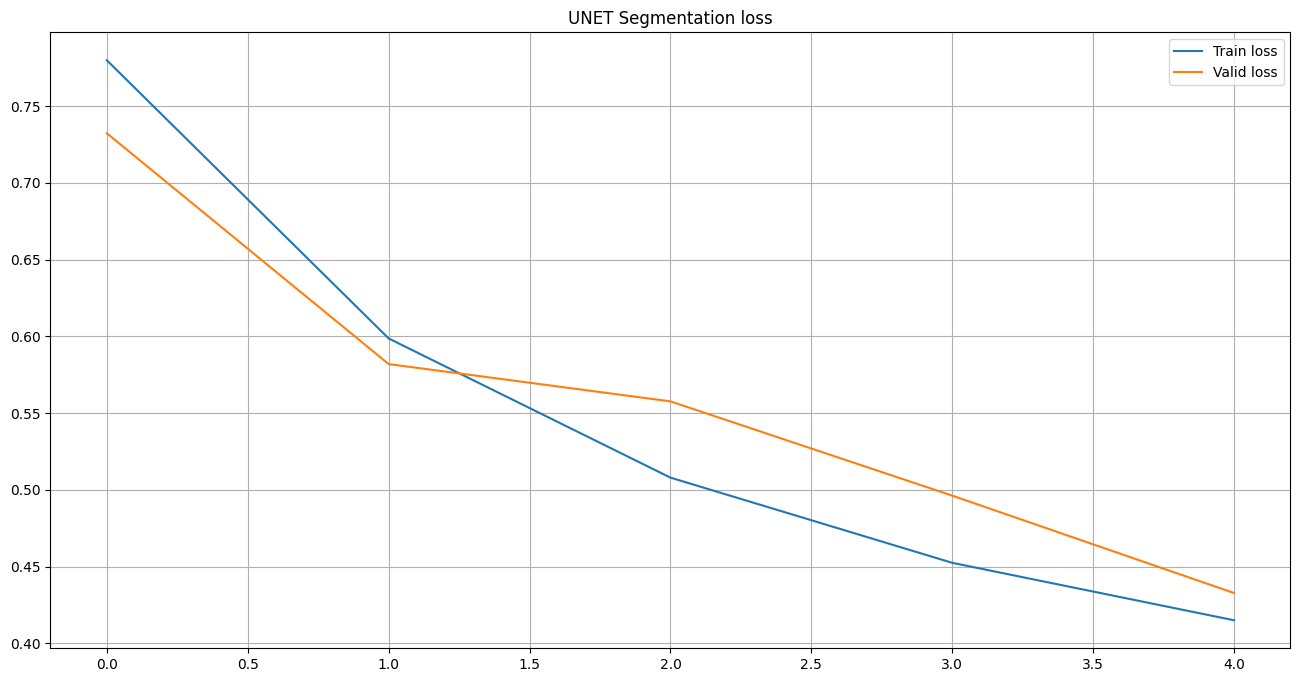

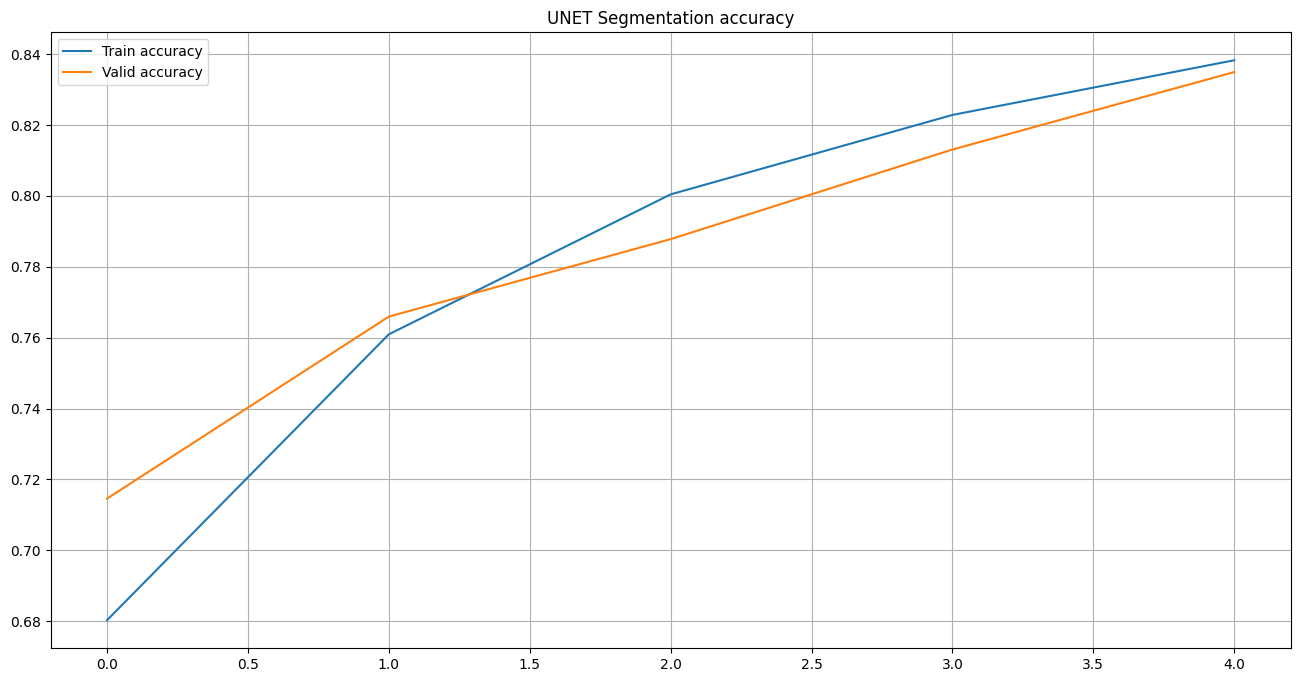

Train:   2%|▏         | 4/230 [00:04<04:19,  1.15s/it]


KeyboardInterrupt: ignored

In [7]:
whole_train_valid_cycle(model, train_loader, valid_loader, optimizer, loss_fn, device, threshold=0.88, title='UNET Segmentation')

In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/SpaceDogs/best_model.pth')

### Проверка результатов

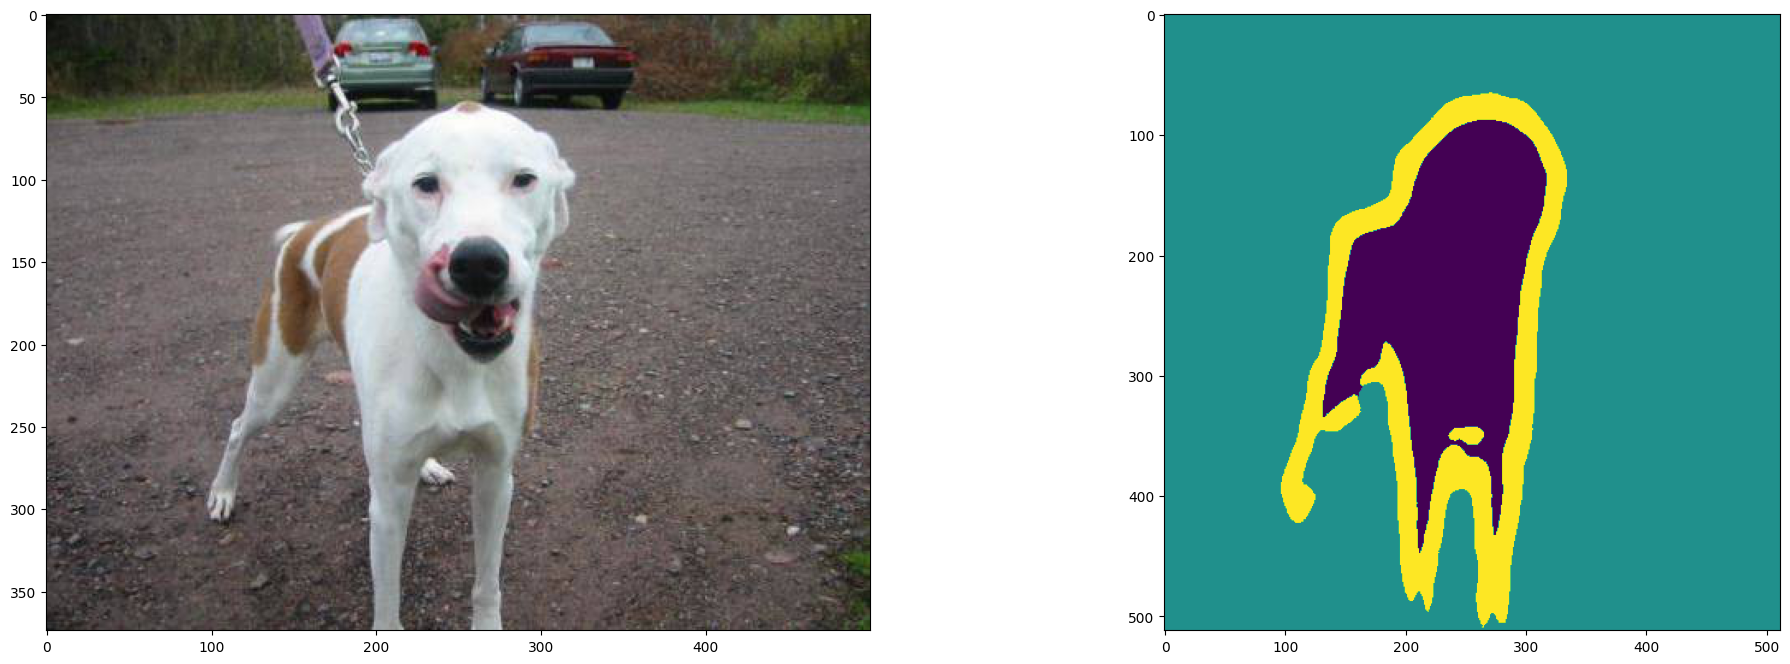

In [ ]:
x = Image.open('/content/drive/MyDrive/SpaceDogs/test_data/dog.8965.jpg')

transform = T.Compose([T.Resize((512, 512)), T.ToTensor(),])

to_pil = T.ToPILImage()

prediction = model(transform(x).unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]

fig, ax = plt.subplots(1, 2, figsize=(24, 8), facecolor='white')

ax[0].imshow(x)
ax[1].imshow(to_pil(prediction.to(torch.uint8)))

### Вывод
Маски формируются достаточно точно, можно переходить к стадии создания сервиса